# Amazu CTR 训练数据特征工程

In [1]:
#首先 import 必要的模块
import pandas as pd
import numpy as np
import random

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 1、准备数据

### 1.1 读取数据

In [ ]:
# 数据路径
dpath = './data/'

filename = "train.csv"
n = sum(1 for line in open(dpath + filename))
s = 500000 #desired sample size
# 随机取样
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
train = pd.read_csv(dpath + filename, skiprows=skip)

# # 由于数据量过大，只读取10M
# # 用迭代器进行分块读取
# train = pd.read_csv(dpath + 'train.csv', nrows=1000000, iterator=True)
# loop = True
# chunkSize = 100000
# chunks = []
# index=0
# while loop:
#     try:
#         print(index)
#         chunk = train.get_chunk(chunkSize)
#         chunks.append(chunk)
#         index+=1

#     except StopIteration:
#         loop = False
#         print("Iteration is stopped.")
# print('开始合并')
# train = pd.concat(chunks, ignore_index= True)

# train.head()

In [3]:
# 数据路径
dpath = './data/'

filename = "train.csv"
n = sum(1 for line in open(dpath + filename))
print("Num of data is %d" % n)

Num of data is 40428968


In [4]:
# 一小部分训练集转为csv
train.to_csv(dpath + 'train_tiny.csv', index=False, header=True)
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10014385711019128754,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,-1,79
1,10019341288757450780,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15707,320,50,1722,0,35,-1,79
2,10024331030544393307,1,14102100,1002,0,f727f4e0,fcb30e54,50e219e0,ecad2386,7801e8d9,...,0,0,6616,320,50,576,2,35,100131,32
3,10065138335302585931,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,...,1,2,6559,320,50,571,2,39,-1,32
4,10077489368961027234,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,e96166c7,2347f47a,...,1,0,18993,320,50,2161,0,35,100148,157


### 1.2 数据分类

In [5]:
ID = train['id']
y_train = train['click']
X_train = train.drop(['id', 'click'], axis=1)

#保存特征名字以备后用
feat_names = X_train.columns

# GBDT做特征工程只适合输入数值型和值空间小的离散型数据
# 把数据分为值空间小和值空间大两类
smallroom_features = ['hour', 'C1', 'banner_pos', 
                      'site_category', 'app_category', 
                      'device_type', 'device_conn_type', 'C15', 
                      'C16', 'C18', 'C19', 'C21']
bigroom_features = ['site_id', 'site_domain', 'app_id', 
                    'app_domain', 'device_id', 'device_ip', 
                    'device_model', 'C14', 'C17', 'C20']
numerical_features = ['hour', 'C1', 'banner_pos', 
                      'device_type', 'device_type', 'device_conn_type', 
                      'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
categorical_features = ['site_id', 'site_domain', 'site_category', 
                        'app_id', 'app_domain', 'app_category', 
                        'device_id', 'device_ip', 'device_model']

In [6]:
X_train.head()

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15704,320,50,1722,0,35,-1,79
1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15707,320,50,1722,0,35,-1,79
2,14102100,1002,0,f727f4e0,fcb30e54,50e219e0,ecad2386,7801e8d9,07d7df22,2ad16ba3,...,0,0,6616,320,50,576,2,35,100131,32
3,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,8ded1f7a,a99f214a,...,1,2,6559,320,50,571,2,39,-1,32
4,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,e96166c7,2347f47a,0f2161f8,fd47d3a8,...,1,0,18993,320,50,2161,0,35,100148,157


### 1.3 数据处理

因为LigbtGBM中传入的数据集虽然支持离散特征，但是数据类型必须是数值型，所以需要把DataFrame中的Objective类型转变为int型。这里我用LabelEncoding完成。

In [7]:
# 导入编码工具包
from sklearn import preprocessing

for col in categorical_features:
    le = preprocessing.LabelEncoder()
    le.fit(X_train[col].values.tolist())

    X_train[col] = le.transform(X_train[col].values.tolist())

In [8]:
X_train[categorical_features].head()

,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model
0,281,2183,1,2257,67,0,52589,22911,4285
1,281,2183,1,2257,67,0,52589,146690,2477
2,2195,2260,5,2257,67,0,13215,307518,3590
3,1191,1785,5,29,20,15,52589,255559,3672
4,1191,1785,5,2214,20,3,78383,192902,1452


## 2、LightGBM超参数调优

LightGBM的主要的超参包括：
1. 树的数目n_estimators 和 学习率 learning_rate
2. 树的最大深度max_depth 和 树的最大叶子节点数目num_leaves（注意：XGBoost只有max_depth，LightGBM采用叶子优先的方式生成树，num_leaves很重要，设置成比 2^max_depth 小）
3. 叶子结点的最小样本数:min_data_in_leaf(min_data, min_child_samples)
4. 每棵树的列采样比例：feature_fraction/colsample_bytree
5. 每棵树的行采样比例：bagging_fraction （需同时设置bagging_freq=1）/subsample
6. 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)
​
7. 两个非模型复杂度参数，但会影响模型速度和精度。可根据特征取值范围和样本数目修改这两个参数
1）特征的最大bin数目max_bin：默认255；
2）用来建立直方图的样本数目subsample_for_bin：默认200000。

对n_estimators，用LightGBM内嵌的cv函数调优，因为同XGBoost一样，LightGBM学习的过程内嵌了cv，速度极快。
其他参数用GridSearchCV

In [9]:
MAX_ROUNDS = 10000

In [10]:
# 相同的交叉验证分组
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

### 2.1 n_estimators

In [1]:
#直接调用lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
def get_n_estimators(params , X_train , y_train , early_stopping_rounds=10):
    lgbm_params = params.copy()
#    lgbm_params['num_class'] = 2
     
    lgbmtrain = lgbm.Dataset(X_train , y_train )
     
    #num_boost_round为弱分类器数目，下面的代码参数里因为已经设置了early_stopping_rounds
    #即性能未提升的次数超过过早停止设置的数值，则停止训练
    cv_result = lgbm.cv(lgbm_params , lgbmtrain , num_boost_round=MAX_ROUNDS , nfold=5,  metrics='auc' , early_stopping_rounds=early_stopping_rounds,seed=3 )
     
    print('best n_estimators:' , len(cv_result['auc-mean']))
    print('best cv score:' , cv_result['auc-mean'][-1])
     
    return len(cv_result['auc-mean'])

In [12]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance': 'true',
          'num_leaves': 20,
          'max_depth': 6,
          'learning_rate': 0.1,
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }

n_estimators_1 = get_n_estimators(params , X_train , y_train)

best n_estimators: 680
best cv score: 0.7367788010452213


### 2.2 max_depth

In [13]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance': 'true',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves':20,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

max_depth_s = range(5,20) 
tuned_parameters = dict( max_depth = max_depth_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 18.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', is_unbalance='true',
        learning_rate=0.1, max_bin=127, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=680,
        n_jobs=4, num_leaves=20, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(5, 20)}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='neg_log_loss',
       verbose=5)

In [18]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.5931278957769189
{'max_depth': 14}


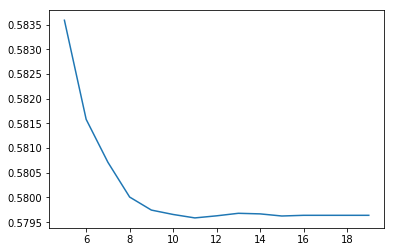

In [17]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = max_depth_s

plt.plot(x_axis, -train_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [16]:
max_depth_1 = list(grid_search.best_params_.values())[0]

### 2.3 num_leaves

In [19]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance': 'true',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

num_leaves_s = range(90,140,10) 
tuned_parameters = dict( num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  9.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', is_unbalance='true',
        learning_rate=0.1, max_bin=127, max_depth=14, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=680,
        n_jobs=4, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'num_leaves': range(90, 140, 10)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [20]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.558156739245373
{'num_leaves': 130}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


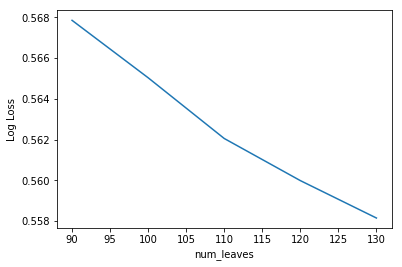

In [21]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

n_leafs = len(num_leaves_s)

x_axis = num_leaves_s
plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_means, yerr=test_stds,label = ' Test')
#plt.errorbar(x_axis, -train_means, yerr=train_stds,label = ' Train')
plt.xlabel( 'num_leaves' )
plt.ylabel( 'Log Loss' )
plt.show()

In [22]:
num_leaves_1 = list(grid_search.best_params_.values())[0]

### 2.4 min_data_in_leaf

In [23]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

min_data_in_leaf_s = range(59,70,1) 
tuned_parameters = dict( min_data_in_leaf = min_data_in_leaf_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed: 25.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=14, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=680,
        n_jobs=4, num_leaves=130, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_data_in_leaf': range(59, 70)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [24]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.4072115442423911
{'min_data_in_leaf': 62}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


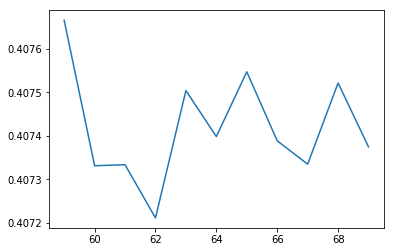

In [25]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_data_in_leaf_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [26]:
min_data_in_leaf_1 = list(grid_search.best_params_.values())[0]

### 2.5 sub_samples/bagging_fraction

In [27]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_data_in_leaf':min_data_in_leaf_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

subsample_s = [i/10.0 for i in range(5,11)]
tuned_parameters = dict( subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 14.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=14, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=62, min_split_gain=0.0,
        n_estimators=680, n_jobs=4, num_leaves=130, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [28]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.40476117744149465
{'subsample': 1.0}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


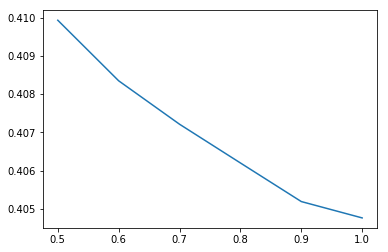

In [29]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = subsample_s

plt.plot(x_axis, -test_means)
plt.show()

In [30]:
subsample_1 = list(grid_search.best_params_.values())[0]

### 2.6 sub_feature/feature_fraction/colsample_bytree

In [31]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_data_in_leaf':min_data_in_leaf_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': subsample_1,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(1,11)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 20.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=14, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=62, min_split_gain=0.0,
        n_estimators=680, n_jobs=4, num_leaves=130, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [32]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.40027143392271863
{'colsample_bytree': 0.1}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


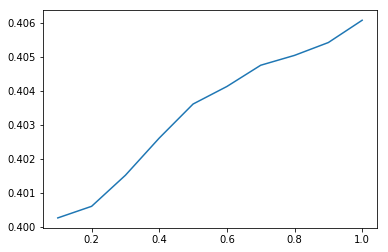

In [33]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = colsample_bytree_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = str(max_depths[i]) +' Test')
#plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = str(max_depths[i]) +' Train')

plt.show()

In [34]:
colsample_bytree_1 = list(grid_search.best_params_.values())[0]

### 2.7 减小学习率，调整n_estimators

In [35]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.01,
          #'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_data_in_leaf':min_data_in_leaf_1,
          'min_child_samples':18,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': subsample_1,
          'bagging_freq': 1,
          'colsample_bytree': colsample_bytree_1
         }
n_estimators_2 = get_n_estimators(params , X_train , y_train)

best n_estimators: 25
best cv score: 0.7093640296321949


### 2.8 用所有训练数据，采用最佳参数重新训练模型

In [36]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.01,
          'n_estimators':n_estimators_2,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_data_in_leaf_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': subsample_1,
          'bagging_freq': 1,
          'colsample_bytree': colsample_bytree_1,
         }

lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_train)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.1, importance_type='split', learning_rate=0.01,
        max_bin=127, max_depth=14, min_child_samples=62,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=25,
        n_jobs=4, num_leaves=130, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

## 3、保存模型，用于后续测试

In [37]:
import pickle

pickle.dump(lg, open("Train_LightGBM.pkl", 'wb'))

### 特征重要性

In [38]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [39]:
df

,columns,importance
14,C14,433
10,device_ip,339
11,device_model,287
4,site_domain,286
6,app_id,256
20,C20,193
7,app_domain,183
21,C21,181
19,C19,173
17,C17,106


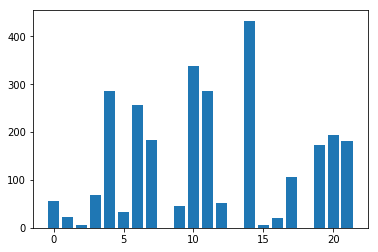

In [40]:
plt.bar(range(len(lg.feature_importances_)), lg.feature_importances_)
plt.show()

## 4、保存结果

### 4.1 预测叶子节点

In [41]:
lgb_leaves = lg.predict(X_train, pred_leaf=True)
print(lgb_leaves)

[[ 98   7 105 ...  94 114  93]
 [ 98 122 105 ...  68 114  93]
 [ 86  68  76 ...  58 114  95]
 ...
 [ 41 128  65 ...  22  46  49]
 [ 41  24  37 ... 108   8  65]
 [ 41 128  37 ...  28  81  65]]


In [42]:
lgb_leaves.shape

(500000, 25)

### 4.2 保存结果作为新的训练集

In [43]:
# 生成提交结果
out_df = pd.DataFrame(lgb_leaves)

columns = np.empty(lgb_leaves.shape[1], dtype=object)
for i in range(lgb_leaves.shape[1]):
    columns[i] = 'Class_' + str(i+1)
    
out_df.columns = columns

out_df.head()

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,...,Class_16,Class_17,Class_18,Class_19,Class_20,Class_21,Class_22,Class_23,Class_24,Class_25
0,98,7,105,27,126,31,127,119,0,36,...,19,11,0,31,66,3,8,94,114,93
1,98,122,105,59,77,31,76,119,0,98,...,19,11,66,124,95,3,2,68,114,93
2,86,68,76,58,16,54,16,51,1,50,...,19,10,35,68,45,0,104,58,114,95
3,41,61,70,128,55,24,54,7,1,92,...,74,11,124,45,100,3,53,22,0,65
4,41,28,12,60,11,31,11,61,1,38,...,22,11,87,3,44,3,36,126,36,112


In [44]:
# 连接id和click
out_df = pd.concat([ID, y_train, out_df], axis=1, ignore_index=True)

In [45]:
# 设置输出数据列名
names_1 = ['id', 'click']
names_2 = columns
out_feat_names = []
out_feat_names.extend(names_1)
out_feat_names.extend(names_2)

out_df.columns = out_feat_names
out_df.head()

,id,click,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,...,Class_16,Class_17,Class_18,Class_19,Class_20,Class_21,Class_22,Class_23,Class_24,Class_25
0,10014385711019128754,0,98,7,105,27,126,31,127,119,...,19,11,0,31,66,3,8,94,114,93
1,10019341288757450780,0,98,122,105,59,77,31,76,119,...,19,11,66,124,95,3,2,68,114,93
2,10024331030544393307,1,86,68,76,58,16,54,16,51,...,19,10,35,68,45,0,104,58,114,95
3,10065138335302585931,0,41,61,70,128,55,24,54,7,...,74,11,124,45,100,3,53,22,0,65
4,10077489368961027234,0,41,28,12,60,11,31,11,61,...,22,11,87,3,44,3,36,126,36,112


In [46]:
# 转为csv格式保存
out_df.to_csv(dpath + "train_GBDT.csv", index=False, header=True)

In [47]:
out_df.head()

,id,click,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,...,Class_16,Class_17,Class_18,Class_19,Class_20,Class_21,Class_22,Class_23,Class_24,Class_25
0,10014385711019128754,0,98,7,105,27,126,31,127,119,...,19,11,0,31,66,3,8,94,114,93
1,10019341288757450780,0,98,122,105,59,77,31,76,119,...,19,11,66,124,95,3,2,68,114,93
2,10024331030544393307,1,86,68,76,58,16,54,16,51,...,19,10,35,68,45,0,104,58,114,95
3,10065138335302585931,0,41,61,70,128,55,24,54,7,...,74,11,124,45,100,3,53,22,0,65
4,10077489368961027234,0,41,28,12,60,11,31,11,61,...,22,11,87,3,44,3,36,126,36,112
